# Alternative respiraiton methods


In [49]:
# add root directory to python path
import sys, os
if os.path.join(sys.path[0], '..') not in sys.path:
    sys.path.insert(1, os.path.join(sys.path[0], '..'))

# perform imports
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from sweeprecon.io.ImageData import ImageData

from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.stats import wasserstein_distance


rect not defined defaulting to full FOV


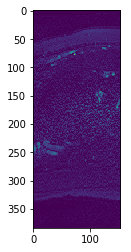

In [50]:
# load image data and crop slices to reduce processing time
image_path = 'data/IMG_3D_cropped.nii.gz'

Image = ImageData(image_path)

Image.square_crop(crop_z=[400,600])

# Check shape
Image.img.shape
plt.imshow(Image.img[:,:,1])

In [51]:
Image.img.shape

(384, 154, 202)

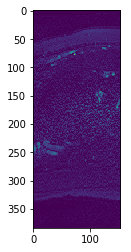

In [53]:
from skimage.feature import register_translation
from scipy import signal

#from skimage.metrics import structural_similarity as ssim
from skimage.measure import compare_ssim

# one off test no loops
img_resp = Image.img[50:100,50:100,:]  # anterior patch with resp
img_static = Image.img[300:350,0:50,:]  # patch with no resp

plt.imshow(Image.img[:,:,1])

test = 50
kern = 25

error = np.zeros(len(np.arange(test-kern,test+kern)))
diffphase = np.zeros(len(np.arange(test-kern,test+kern)))

ssim_resp = np.zeros(len(np.arange(test-kern,test+kern)))
ssim_static = np.zeros(len(np.arange(test-kern,test+kern)))

ssd_resp = np.zeros(len(np.arange(test-kern,test+kern)))
ssd_static = np.zeros(len(np.arange(test-kern,test+kern)))

nmi_resp = np.zeros(len(np.arange(test-kern,test+kern)))
nmi_static = np.zeros(len(np.arange(test-kern,test+kern)))

cc_resp = np.zeros(len(np.arange(test-kern,test+kern)))
cc_static = np.zeros(len(np.arange(test-kern,test+kern)))


def sumsd(img1, img2):
    return np.sum((img1 - img2) ** 2)

def nmi(img1, img2, bins=128):
    hist_2d, x_edges, y_edges = np.histogram2d(img1.ravel(),img2.ravel(),bins=bins)
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def normcrosscor(img1, img2):
    # implement from wiki cross correlation
    sigm1 = np.std(img1)
    sigm2 = np.std(img2)
    npix = img1.size
    return (1/npix) * np.sum( (1/(sigm1*sigm2)) * img1 * img2)

def znormcrosscor(img1, img2):
    # implement from wiki cross correlation
    sigm1 = np.std(img1)
    sigm2 = np.std(img2)
    mu1 = np.mean(img1)
    mu2 = np.mean(img2)
    npix = img1.size
    return (1/npix) * np.sum( (1/(sigm1*sigm2)) * (img1-mu1) * (img2-mu2))
    
    
for nn, zz in enumerate(range(test - kern, test+kern)):
    #shift, error[nn], diffphase[nn] = register_translation(img[:,:,test], img[:,:,zz])
    #cc[:,:,nn] = signal.correlate2d(img[:,:,test], img[:,:,zz])
    ssim_resp[nn] = compare_ssim(img_resp[:,:,zz], img_resp[:,:,test], gaussian_weights=True, sigma=3)
    ssim_static[nn] = compare_ssim(img_static[:,:,zz], img_static[:,:,test], gaussian_weights=True, sigma=3)
    
    ssd_resp[nn] = sumsd(img_resp[:,:,zz], img_resp[:,:,test])
    ssd_static[nn] = sumsd(img_static[:,:,zz], img_static[:,:,test])
    
    nmi_resp[nn] = nmi(img_resp[:,:,zz], img_resp[:,:,test])
    nmi_static[nn] = nmi(img_static[:,:,zz], img_static[:,:,test])
    
    cc_resp[nn] = znormcrosscor(img_resp[:,:,zz], img_resp[:,:,test])
    cc_static[nn] = znormcrosscor(img_static[:,:,zz], img_static[:,:,test])

In [54]:
import statsmodels.api as sm
from scipy.signal import medfilt

from math import ceil

def lowess_sm(x, y, filt_dist_mm=5, iter=5):
    lowess = sm.nonparametric.lowess
    kern = ceil(filt_dist_mm / Image.nii.header["pixdim"][3])
    kern_frac = kern / len(y)
    x = np.arange(0, y.shape[0])
    yest = lowess(y, x, frac=kern_frac, it=iter)
    return yest[:,1]

def medfilt_dist(x, y, filt_dist_mm=5,):
    kern = int(filt_dist_mm / Image.nii.header["pixdim"][3])
    kern = int(np.ceil(kern) // 2 * 2 + 1)  # round up to nearest odd n
    print(kern)
    return medfilt(y, kernel_size=kern)


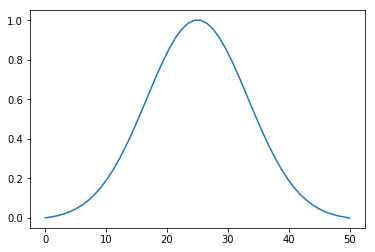

In [55]:

import scipy.stats as stats

x = np.linspace(0, 2*kern, 2*kern)

def gausswindow(x, mu):
    window = stats.norm.pdf(x, mu, mu/3)
    return ((window - np.min(window)) / (np.max(window) - np.min(window)))
    
def linwindow(x,mu):
    # linear ramp up down - doesnt work atm come back to this probably not usefuls
    return np.concat(np.linspace(0,1,mu), np.linspace(1,0,mu))
    
window = gausswindow(x, kern)
plt.plot(x,window)

17
17
17
17


Text(0.5, 1.0, 'local sim static')

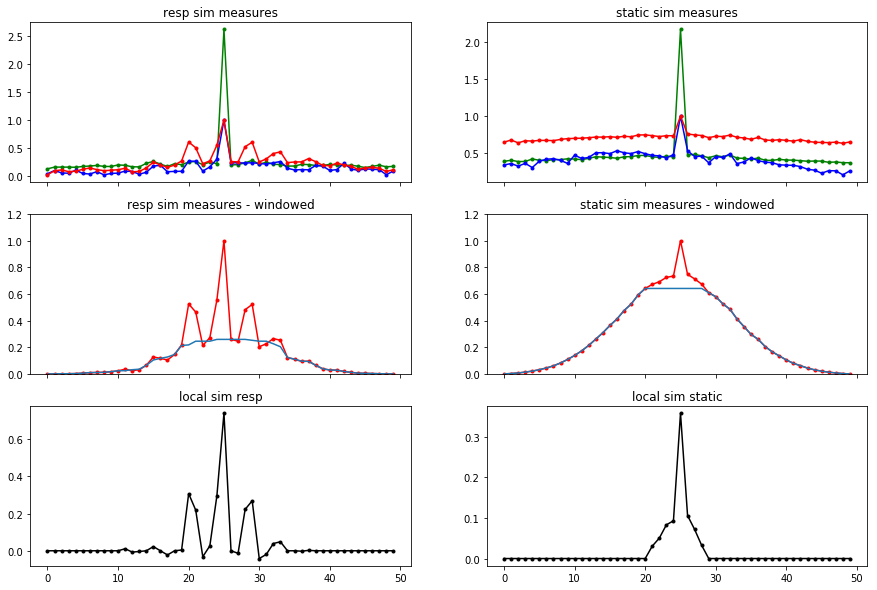

In [56]:
# delete refernce slice
fig, ax = plt.subplots(3, 2, sharex='col', figsize=(15, 10))
filt_dist_mm=5

ax[0,0].set_title('resp sim measures')
ax[0,0].plot(nmi_resp,'g.-')
ax[0,0].plot(ssim_resp,'b.-')
ax[0,0].plot(cc_resp,'r.-')
#ax[0,0].set_ylim([-0.1, 0.8])

ax[0,1].set_title('static sim measures')
ax[0,1].plot(nmi_static,'g.-')
ax[0,1].plot(ssim_static,'b.-')
ax[0,1].plot(cc_static,'r.-')
#ax[0,1].set_ylim([0, 1.0])

ax[1,0].set_title('resp sim measures - windowed')
#ax[1,0].plot(nmi_resp*window,'g.-')
#ax[1,0].plot(ssim_resp*window,'b.-')
ax[1,0].plot((cc_resp*window),'r.-')
ax[1,0].plot(medfilt_dist(x, cc_resp*window, filt_dist_mm=filt_dist_mm))
ax[1,0].set_ylim([0, 1.2])

ax[1,1].set_title('static sim measures - windowed')
#ax[1,1].plot(ssim_static*window,'b.-')
ax[1,1].plot(cc_static*window,'r.-')
ax[1,1].plot(medfilt_dist(x, cc_static*window, filt_dist_mm=filt_dist_mm))
ax[1,1].set_ylim([0, 1.2])

local_sim_resp = (cc_resp*window) - medfilt_dist(x, cc_resp*window, filt_dist_mm=filt_dist_mm)
local_sim_static = (cc_static*window) - medfilt_dist(x, cc_static*window, filt_dist_mm=filt_dist_mm)

ax[2,0].plot(local_sim_resp,'k.-')
ax[2,0].set_title('local sim resp')

ax[2,1].plot(local_sim_static,'k.-')
ax[2,1].set_title('local sim static')

___
Test on full volume

In [135]:
# Formalise for volume
import time
import copy


class local_sim(object):
    
    def __init__(self, img, local_patch_size, windowed=True):
        self.img = img
        self.sim_img = np.zeros((img.shape[0], img.shape[1],img.shape[2],local_patch_size[2]))
        self.local_patch_size = local_patch_size
        self.img_local = np.zeros((local_patch_size[0], local_patch_size[1],img.shape[2]))
        self.window = np.ones((local_patch_size[2],), dtype=int)
        if windowed:
            self.gauss_window(int(local_patch_size[2]/2))
        print(self.sim_img.shape)
                
    def extract_local_patch(self,xx,yy):
        xs = np.arange(xx - self.local_patch_size[0]/2, xx + self.local_patch_size[0]/2).astype(int)
        ys = np.arange(yy - self.local_patch_size[1]/2, yy + self.local_patch_size[1]/2).astype(int)
        
        self.img_local[:,:,:] = self.img[xs, ys, :]

    def local_sim(self, xx, yy):
        
        # loop over target slices
        for tt in range(0, self.img_local.shape[2]-1):
            # loop over test slices
            for nn, zz in enumerate(range(tt - int(self.local_patch_size[2]/2), tt + int(self.local_patch_size[2]/2))):
                if (zz < 0) or (zz > self.sim_img.shape[2]-1):
                    cc_resp[nn] = 0
                else:
                    cc_resp[nn] = znormcrosscor(img_resp[:,:,zz], img_resp[:,:,tt])
            
            self.sim_img[xx,yy,tt,:] = cc_reps
            
            #cc_resp = cc_resp * self.window

    def gauss_window(self, mu):
        x = np.linspace(0, 2*mu, 2*mu)
        window = stats.norm.pdf(x, mu, mu/3)
        self.window = ((window - np.min(window)) / (np.max(window) - np.min(window)))
        
    def znormcrosscor(img1, img2):
        # implement from wiki cross correlation
        return (1/img1.size) * np.sum( (1/(np.std(img1)*np.std(img2))) * (img1-np.mean(img1)) * (img2-np.mean(img2)))    
    
    def optimal_slices(self, sample_density=0.02):
        nsx = sample_density * self.img.shape[0]
        nsy = sample_density * self.img.shape[1]
        
        self.sx = np.linspace(self.local_patch_size[0], self.img.shape[0] - self.local_patch_size[0], nsx).astype(int)
        self.sy = np.linspace(self.local_patch_size[1], self.img.shape[1] - self.local_patch_size[1], nsy).astype(int)
        
        for xx in self.sx:
            for yy in self.sy:
                print((xx,yy))
                self.extract_local_patch(xx,yy)
                self.local_sim(xx,yy)
        
        # for each x(sample_density)
        # for each y(sample_density)
        # extract local region
        # for ecah t(all)
        # define local sim and store
        # interpolate slice density
        # find optimal interpolation weights for coherent volume
        
        return

In [136]:
localsim = local_sim(Image.img, (64,64,50))
slices = localsim.optimal_slices()


(384, 154, 202, 50)
(64, 64)
(64, 77)
(64, 90)
(106, 64)
(106, 77)
(106, 90)
(149, 64)
(149, 77)
(149, 90)
(192, 64)
(192, 77)
(192, 90)
(234, 64)
(234, 77)
(234, 90)
(277, 64)
(277, 77)
(277, 90)
(320, 64)
(320, 77)
(320, 90)
